In [14]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from circadian.models import Skeldon23
from circadian.lights import LightSchedule
from utils.helper_functions import H_thresholds

In [29]:
light_data_location = 'data/light_schedules/'

dt = 0.005 # hours
days = 14.0
regular_indoor_lux = 500.0
time = np.arange(0, 24*days, dt)

parameters = {
    'mu': 19.0,
    'Delta': 6.0,
    'chi': 11.0,
    'k': 0.55,
    'p': 0.6,
    'tauc': 24.2,
}

lights_on_start_times = [4, 5, 6, 7, 8]
regular_light_options = []


for lights_on in lights_on_start_times:
    regular_light = LightSchedule.Regular(regular_indoor_lux, lights_on=lights_on, lights_off=lights_on + 16)
    regular_light_options.append(regular_light(time))

In [30]:
forced_wakeup_threshold = 0.5 # lux

chang14_ebook_first_light = np.load(f"{light_data_location}/chang14_ebook_first_light.npy")
chang14_ebook_second_light = np.load(f"{light_data_location}/chang14_ebook_second_light.npy")
chang14_high_ebook_first_light = np.load(f"{light_data_location}/chang14_high_ebook_first_light.npy")
chang14_high_ebook_second_light = np.load(f"{light_data_location}/chang14_high_ebook_second_light.npy")

results = {}

idx = 0
for regular_light in tqdm(regular_light_options):
    start_time = lights_on_start_times[idx]
    idx += 1
    # Equilibrate
    mu = parameters['mu']
    delta = parameters['Delta']
    chi = parameters['chi']
    p = parameters['p']
    k = parameters['k']
    tauc = parameters['tauc']

    parameters = {'S0': 1.0, 'mu': mu, 'Delta': delta, 'chi': chi, 'p': p, 'k': k, 'tauc': tauc, 
                  'forced_wakeup_light_threshold': forced_wakeup_threshold,}
    equilibration_model = Skeldon23(params=parameters)
    initial_condition = equilibration_model.equilibrate(time, regular_light, num_loops=10)

    # Simulate
    parameters = {
        'S0': 1.0,
        'mu': mu, 'Delta': delta, 'chi': chi,
        'p': p, 'k': k, 'tauc': tauc,
        'forced_wakeup_light_threshold': forced_wakeup_threshold,
    }
    # Chang14 Ebook first simulation
    chang14_ebook_first_model = Skeldon23(params=parameters)
    chang14_ebook_first_trajectory = chang14_ebook_first_model.integrate(time, 
                                                                        initial_condition=initial_condition, 
                                                                        input=chang14_ebook_first_light)
    
    # Chang14 Ebook second simulation
    chang14_ebook_second_model = Skeldon23(params=parameters)
    chang14_ebook_second_trajectory = chang14_ebook_second_model.integrate(time, 
                                                        initial_condition=initial_condition,
                                                        input=chang14_ebook_second_light)
    chang14_ebook_second_H_plus, chang14_ebook_second_H_minus = H_thresholds(chang14_ebook_second_model, chang14_ebook_second_trajectory)

    ebook_first_cbtmin = chang14_ebook_first_model.cbt(chang14_ebook_first_trajectory)[:-1]
    ebook_second_cbtmin = chang14_ebook_second_model.cbt(chang14_ebook_second_trajectory)[:-1]

    results[start_time] = {
        'ebook_first_cbtmin': ebook_first_cbtmin,
        'ebook_second_cbtmin': ebook_second_cbtmin,
    }

    # # Chang14 High Ebook first simulation
    # chang14_high_ebook_first_model = Skeldon23(params=parameters)
    # chang14_high_ebook_first_trajectory = chang14_high_ebook_first_model.integrate(time,
    #                                                                             initial_condition=initial_condition,
    #                                                                             input=chang14_high_ebook_first_light)
    # chang14_high_ebook_first_H_plus, chang14_high_ebook_first_H_minus = H_thresholds(chang14_high_ebook_first_model, chang14_high_ebook_first_trajectory)
    # # Chang14 High Ebook second simulation
    # chang14_high_ebook_second_model = Skeldon23(params=parameters)
    # chang14_high_ebook_second_trajectory = chang14_high_ebook_second_model.integrate(time,
    #                                                                             initial_condition=initial_condition,
    #                                                                             input=chang14_high_ebook_second_light)
    # chang14_high_ebook_second_H_plus, chang14_high_ebook_second_H_minus = H_thresholds(chang14_high_ebook_second_model, chang14_high_ebook_second_trajectory)
    # # Realistic Ebook first simulation
    # realistic_ebook_first_model = Skeldon23(params=parameters)
    # realistic_ebook_first_trajectory = realistic_ebook_first_model.integrate(time, 
    #                                                                         initial_condition=initial_condition, 
    #                                                                         input=realistic_ebook_first_light)
    # realistic_ebook_first_H_plus, realistic_ebook_first_H_minus = H_thresholds(realistic_ebook_first_model, realistic_ebook_first_trajectory)
    # # Realistic Ebook second simulation
    # realistic_ebook_second_model = Skeldon23(params=parameters)
    # realistic_ebook_second_trajectory = realistic_ebook_second_model.integrate(time, 
    #                                                                         initial_condition=initial_condition,
    #                                                                         input=realistic_ebook_second_light)
    # realistic_ebook_second_H_plus, realistic_ebook_second_H_minus = H_thresholds(realistic_ebook_second_model, realistic_ebook_second_trajectory)
    # # Save data
    # np.savez(f"{sim_save_path}/{light_condition}_light_chang14_simulation_{idx}.npz",
    #         time=time,
    #         parameters=parameters,
    #         initial_condition=initial_condition,
    #         regular_trajectory_states=regular_trajectory.states,
    #         regular_light=regular_light,
    #         regular_sleep=regular_model.sleep_state,
    #         regular_H_plus=regular_H_plus,
    #         regular_H_minus=regular_H_minus,
    #         chang14_ebook_first_trajectory_states=chang14_ebook_first_trajectory.states,
    #         chang14_ebook_first_light=chang14_ebook_first_light,
    #         chang14_ebook_first_sleep=chang14_ebook_first_model.sleep_state,
    #         chang14_ebook_first_H_plus=chang14_ebook_first_H_plus,
    #         chang14_ebook_first_H_minus=chang14_ebook_first_H_minus,
    #         chang14_ebook_second_trajectory_states=chang14_ebook_second_trajectory.states,
    #         chang14_ebook_second_light=chang14_ebook_second_light,
    #         chang14_ebook_second_sleep=chang14_ebook_second_model.sleep_state,
    #         chang14_ebook_second_H_plus=chang14_ebook_second_H_plus,
    #         chang14_ebook_second_H_minus=chang14_ebook_second_H_minus,
    #         chang14_high_ebook_first_trajectory_states=chang14_high_ebook_first_trajectory.states,
    #         chang14_high_ebook_first_light=chang14_high_ebook_first_light,
    #         chang14_high_ebook_first_sleep=chang14_high_ebook_first_model.sleep_state,
    #         chang14_high_ebook_first_H_plus=chang14_high_ebook_first_H_plus,
    #         chang14_high_ebook_first_H_minus=chang14_high_ebook_first_H_minus,
    #         chang14_high_ebook_second_trajectory_states=chang14_high_ebook_second_trajectory.states,
    #         chang14_high_ebook_second_light=chang14_high_ebook_second_light,
    #         chang14_high_ebook_second_sleep=chang14_high_ebook_second_model.sleep_state,
    #         chang14_high_ebook_second_H_plus=chang14_high_ebook_second_H_plus,
    #         chang14_high_ebook_second_H_minus=chang14_high_ebook_second_H_minus,
    #         realistic_ebook_first_trajectory_states=realistic_ebook_first_trajectory.states,
    #         realistic_ebook_first_light=realistic_ebook_first_light,
    #         realistic_ebook_first_sleep=realistic_ebook_first_model.sleep_state,
    #         realistic_ebook_first_H_plus=realistic_ebook_first_H_plus,
    #         realistic_ebook_first_H_minus=realistic_ebook_first_H_minus,
    #         realistic_ebook_second_trajectory_states=realistic_ebook_second_trajectory.states,
    #         realistic_ebook_second_light=realistic_ebook_second_light,
    #         realistic_ebook_second_sleep=realistic_ebook_second_model.sleep_state,
    #         realistic_ebook_second_H_plus=realistic_ebook_second_H_plus,
    #         realistic_ebook_second_H_minus=realistic_ebook_second_H_minus,
    # )

  0%|          | 0/5 [00:00<?, ?it/s]

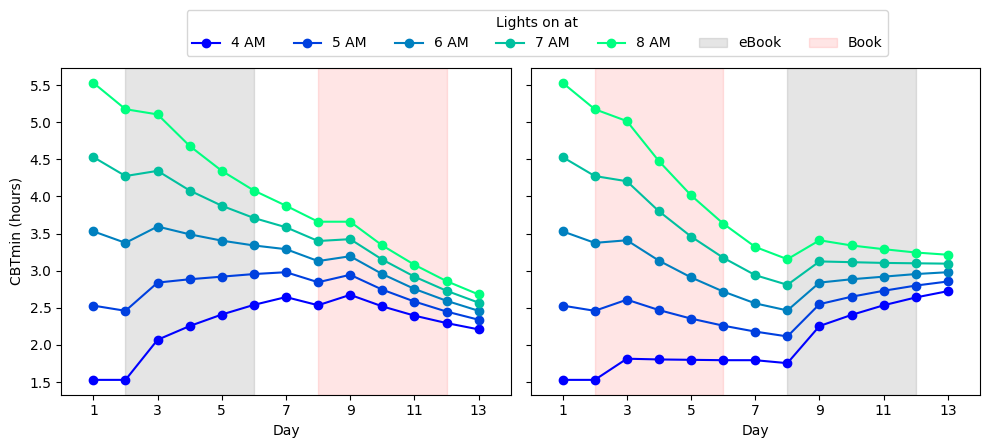

In [43]:

colors = plt.get_cmap('winter')(np.linspace(0, 1, len(lights_on_start_times)))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, lights_on in enumerate(lights_on_start_times):
    ebook_first_cbtmin = results[lights_on]['ebook_first_cbtmin']
    ebook_second_cbtmin = results[lights_on]['ebook_second_cbtmin']

    days = np.arange(1, len(ebook_first_cbtmin) + 1)

    normalized_ebook_first_cbtmin = ebook_first_cbtmin - np.arange(1, len(ebook_first_cbtmin) + 1) * 24 + 24
    normalized_ebook_second_cbtmin = ebook_second_cbtmin - np.arange(1, len(ebook_second_cbtmin) + 1) * 24 + 24

    # if any datapoint is above 12, subtract 24
    for i, val in enumerate(normalized_ebook_first_cbtmin):
        if val > 12:
            normalized_ebook_first_cbtmin[i] -= 24
    for i, val in enumerate(normalized_ebook_second_cbtmin):
        if val > 12:
            normalized_ebook_second_cbtmin[i] -= 24


    axs[0].plot(days, normalized_ebook_first_cbtmin,
                marker='o', color=colors[idx],
                label=f'{lights_on} AM',)
    
    axs[1].plot(days, normalized_ebook_second_cbtmin,
                marker='o', color=colors[idx],
                label=f'{lights_on} AM',)

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('CBTmin (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Lights on at',
        bbox_to_anchor=(0.9, 1.05), ncol=7)
fig.subplots_adjust(wspace=0.01)

# fig.subplots_adjust(wspace=0.01)
# fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
#              y=1.05)

plt.tight_layout()
plt.show()